In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


import pandas as pd
import numpy as np
import warnings
import sys
import pickle

In [3]:
# suppressing warning messages

warnings.filterwarnings('ignore')

In [4]:
# importing scripts

sys.path.insert(1, '../scripts')

from data_viz import Data_Viz
from data_cleaning import DataCleaner
from data_transformation import DataTransformer

DV = Data_Viz("../logs/data_model_notebook.log")
DC = DataCleaner("../logs/data_model_notebook.log")
DT = DataTransformer("../logs/data_model_notebook.log")

In [5]:
# importing the data

train = pd.read_csv("../data/train_store.csv")

In [6]:
DV.summ_columns(train)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Store,0,0.0,int64,1115
1,DayOfWeek,0,0.0,int64,7
2,Date,0,0.0,object,942
3,Sales,0,0.0,float64,13194
4,Customers,0,0.0,float64,1423
5,Open,0,0.0,int64,2
6,Promo,0,0.0,int64,2
7,StateHoliday,0,0.0,object,4
8,SchoolHoliday,0,0.0,int64,2
9,StoreType,0,0.0,object,4


In [7]:
# selecting out some features

deselect_list = ["Store", "Date", "PromoInterval", "Promo2", "Promo2SinceYear", "Promo2SinceWeek"]
train_cl = train[train.columns[~train.columns.isin(deselect_list)]]
sales = train_cl.pop("Sales")
train_cl.insert(0,"Sales", sales)
train_cl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sales                1017209 non-null  float64
 1   DayOfWeek            1017209 non-null  int64  
 2   Customers            1017209 non-null  float64
 3   Open                 1017209 non-null  int64  
 4   Promo                1017209 non-null  int64  
 5   StateHoliday         1017209 non-null  object 
 6   SchoolHoliday        1017209 non-null  int64  
 7   StoreType            1017209 non-null  object 
 8   Assortment           1017209 non-null  object 
 9   CompetitionDistance  1017209 non-null  float64
 10  Year                 1017209 non-null  int64  
 11  Month                1017209 non-null  int64  
 12  DayOfMonth           1017209 non-null  int64  
 13  WeekOfYear           1017209 non-null  int64  
 14  weekday              1017209 non-null  int64  
 15

In [8]:
categorical_lis, numerical_lis = DT.sep_cat_num(train_cl)
categorical_lis.head()

,StateHoliday,StoreType,Assortment
0,No Holiday,c,a
1,No Holiday,a,a
2,No Holiday,a,a
3,No Holiday,c,c
4,No Holiday,a,a


In [9]:
DV.summ_columns(train_cl)

,variables,missing_count,missing_percent_(%),data_type,unique_values
0,Sales,0,0.0,float64,13194
1,DayOfWeek,0,0.0,int64,7
2,Customers,0,0.0,float64,1423
3,Open,0,0.0,int64,2
4,Promo,0,0.0,int64,2
5,StateHoliday,0,0.0,object,4
6,SchoolHoliday,0,0.0,int64,2
7,StoreType,0,0.0,object,4
8,Assortment,0,0.0,object,3
9,CompetitionDistance,0,0.0,float64,654


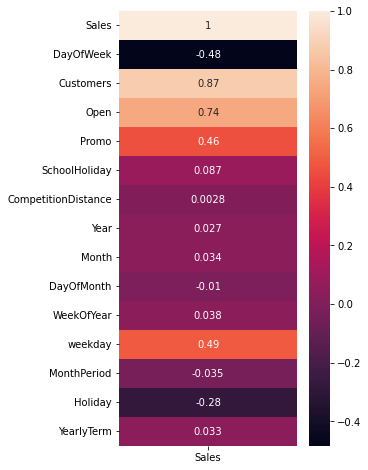

In [10]:
# checking correlations

plt.figure(figsize=(4, 8))
sns.heatmap(numerical_lis.corr().loc['Sales',:].to_frame(), annot=True)
plt.show()

In [11]:
#selecting highly correlated features only as predictors

selection_list = ["Sales", "DayOfWeek", "Customers", "Open", "Promo", "Assortment", "StoreType", "StateHoliday"]
train_df = train_cl[selection_list]

In [12]:
# setup our pipeline
# cat-num conversion
# scaling
# splitting
# algorithm

pipe = Pipeline(steps = [
                        ("labeling", FunctionTransformer(DT.cat_labeler, kw_args={"cat_cols": categorical_lis.columns.to_list()})),
                        ("scaling", FunctionTransformer(DT.scaler)), 
                        ("target", FunctionTransformer(DT.target_feature, kw_args={"f":1, "t":0})),
                        ("split", FunctionTransformer(DT.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8}))
                        ])

sets = pipe.fit_transform(train_cl)

catagories successfully labeled
Data successfully scaled
target and features separated
data successfully splitted


In [13]:

regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(sets[0], sets[1]) 

RandomForestRegressor(random_state=0)

### Loss functions

- MAE = Mean Absolute Eror. this is robhust when outliers are present in the data. 
- MSE = Mean Squared Eror. This function penalizes large errors and it is easiy to calculate gradients.

Since there are no outliers in the data, MSE is chosen.



In [15]:

Y_pred = regressor.score(sets[2], sets[3])
Y_pred

0.8573462409070765

### calculating feature importance

<BarContainer object of 6 artists>

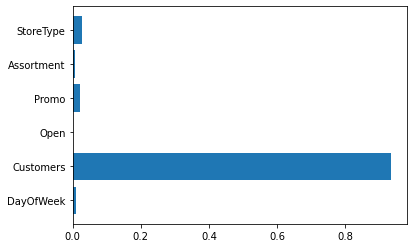

In [19]:
features, target= DT.target_feature(train_cl, 1, 0)
plt.barh(features, regressor.feature_importances_)

In [25]:
# datetime object containing current date and time
now = datetime.now()
time = now.strftime("%d-%m-%Y-%H-%M-%S")
filename = "../models/"+str(time)+'.pkl'
pickle.dump(regressor, open(filename, 'wb'))

In [26]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(sets[4], sets[5])
print(result)

0.8598458803249744
